
# Tokopedia Product Reviews — Text Classification (Sentiment)

This notebook walks through an **end‑to‑end sentiment classification** pipeline on Indonesian e‑commerce reviews (**Tokopedia**).  

> **Workflow**: Data Loading → Preprocessing → Embedding → Training → Evaluation → Prediction 

**Dataset**: Tokopedia Product Reviews (≈40k rows). Original source on Kaggle; a maintained mirror also exists on Hugging Face Datasets.  
- Kaggle: `farhan999/tokopedia-product-reviews` (requires Kaggle login to access/download)  
- Hugging Face mirror & license: **Apache-2.0**. See the dataset card for details. *(You must still comply with Tokopedia's TOS and applicable laws when using scraped data.)*


## 📚 Dataset & License

- **Name**: Tokopedia Product Reviews (≈40k rows, Indonesian)  
- **Source**: Originally shared on Kaggle by *farhan999*; community mirror on Hugging Face Datasets: `farhamu/tokopedia-product-reviews-2019` (license: **Apache-2.0**).  
- **Usage**: Ensure compliance with **Tokopedia Terms of Service** and the dataset's license. If you export/redistribute, include proper **attribution** and license text.
- **Ethics**: Reviews are user-generated content; be mindful of bias and do not attempt to deanonymize individuals.


### Import Necessary Libraries

In [74]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import faiss
import re
import seaborn as sns
import joblib

from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

### Data Loading

In [79]:
DATA_PATH = "data/tokopedia-product-reviews-2019.csv"

In [80]:
# Load Dataset
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH, index_col=0)
    print(f"Loaded Full Dataset : {DATA_PATH} -> {df.shape}")
else:
    raise FileNotFoundError(
        "No CSV found. Please place a CSV in directory"
    )

Loaded Full Dataset : data/tokopedia-product-reviews-2019.csv -> (40607, 8)


In [81]:
#Display Basic Info
print("Dataset Overview : ")
print(f"Columns : {df.columns.tolist()}")
print(f"\nFirst 5 Rows : ")
df.head()

Dataset Overview : 
Columns : ['text', 'rating', 'category', 'product_name', 'product_id', 'sold', 'shop_id', 'product_url']

First 5 Rows : 


,text,rating,category,product_name,product_id,sold,shop_id,product_url
1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40607 entries, 1 to 40893
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          40607 non-null  object
 1   rating        40607 non-null  int64 
 2   category      40607 non-null  object
 3   product_name  40607 non-null  object
 4   product_id    40607 non-null  int64 
 5   sold          40593 non-null  object
 6   shop_id       40607 non-null  int64 
 7   product_url   40607 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


### Exploratory Data Analysis

Performing Exploratory Data Analysis...

 Dataset Statistics:
Missing values: 
 text             0
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
dtype: int64
Duplicate Data :  0


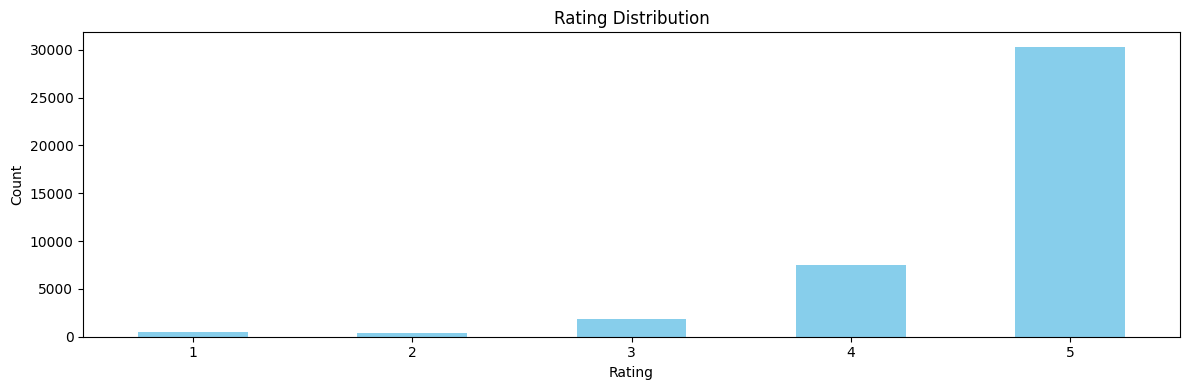

In [83]:
def perform_eda(df):
    """
    Comprehensive exploratory data analysis
    """
    
    print("Performing Exploratory Data Analysis...")
    
    # Basic statistics
    print("\n Dataset Statistics:")
    print("Missing values: \n", df.isna().sum())
    print("Duplicate Data : ", df.duplicated().sum())
    
    # Rating distribution
    if 'rating' in df.columns:
        plt.figure(figsize=(12, 4))
        df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
        plt.title('Rating Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return df

df_eda = perform_eda(df)

In [84]:
# Check the value of Rating Columns
uniques_counts = df['rating'].value_counts()
print(uniques_counts)

rating
5    30311
4     7546
3     1825
1      543
2      382
Name: count, dtype: int64


### Preprocessing
Light Cleaning & Labelling. Avoid over-cleaning; keep meaning.

In [85]:
# Light Cleaning 
def light_clean(text):
    text = re.sub(r"\s+", " ",text).strip() # Normalize whitespace / newlines
    return text

df['text'] = df['text'].apply(light_clean)

In [86]:
# Map Rating -> Sentiment
def map_rating_to_label(label):
    if label >= 4: return "positive"
    if label <= 2: return "negative"
    return "neutral"

df_sentiment = df.dropna(subset=["text", "rating"]).copy()
df_sentiment['label'] = df['rating'].astype(int).map(map_rating_to_label)
df_sentiment[["text","rating","label"]].head()

,text,rating,label
1,Barang sesuai pesanan dan cepat sampai,5,positive
2,Barang bagus harga murah,5,positive
3,Paket rapi...mantap....cepat....sampe ke tujuan,5,positive
4,ya saya puas dgn barangnya,5,positive
5,Responya luar biasa b mantap,5,positive


### Train / Val / Test Split (Stratified)

In [87]:
# Test Set 
X_trainval, X_test = train_test_split(df_sentiment, test_size=0.15, random_state=42, stratify=df_sentiment["label"])

# Split 85% to train & validation
# Validation 15% so 15% of 85% -> 0.176
X_train, X_val = train_test_split(X_trainval, test_size=0.1765, random_state=42, stratify=X_trainval["label"])  # => ~70/15/15 total

for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print(name, X["label"].value_counts(normalize=True).round(3))

train label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64
val label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64
test label
positive    0.932
neutral     0.045
negative    0.023
Name: proportion, dtype: float64


In [88]:
print("FULL:", df_sentiment["label"].value_counts(normalize=True).round(3).to_dict())
print("TRAIN:", X_train["label"].value_counts(normalize=True).round(3).to_dict())
print("VAL  :", X_val["label"].value_counts(normalize=True).round(3).to_dict())
print("TEST :", X_test["label"].value_counts(normalize=True).round(3).to_dict())

FULL: {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
TRAIN: {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
VAL  : {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}
TEST : {'positive': 0.932, 'neutral': 0.045, 'negative': 0.023}


The Stratification is worked make the FULL, TRAIN, VAL, TEST at the same class ratios.

The dataset is heavily imbalanced. After mapping ratings to sentiment labels, **about 93.2 % of all reviews are positive**, while neutral reviews make up only ~4.5 % and negative reviews ~2.3 %.

### Embedding (Sentence-Transformers / HF)
encode texts into vectors.

In [89]:
# good for Indonesian language
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  

def embed(texts):
    # Converts list into a 2D Numpy array
    # Casts to Float32 required for FAISS
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

# Pandas Column -> Python list -> 2D Numpy array of numbers (numeric vectors)
emb_train = embed(X_train["text"].tolist())
emb_val   = embed(X_val["text"].tolist())
emb_test  = embed(X_test["text"].tolist())

# Label
y_train = X_train["label"].tolist()
y_val   = X_val["label"].tolist()
y_test  = X_test["label"].tolist()

### Model Training

=== VALIDATION ===
              precision    recall  f1-score   support

    negative      0.227     0.698     0.342       139
     neutral      0.088     0.369     0.142       274
    positive      0.978     0.778     0.867      5679

    accuracy                          0.758      6092
   macro avg      0.431     0.615     0.450      6092
weighted avg      0.921     0.758     0.822      6092

=== TEST ===
              precision    recall  f1-score   support

    negative      0.222     0.676     0.334       139
     neutral      0.097     0.398     0.156       274
    positive      0.976     0.781     0.868      5679

    accuracy                          0.762      6092
   macro avg      0.432     0.618     0.453      6092
weighted avg      0.919     0.762     0.824      6092



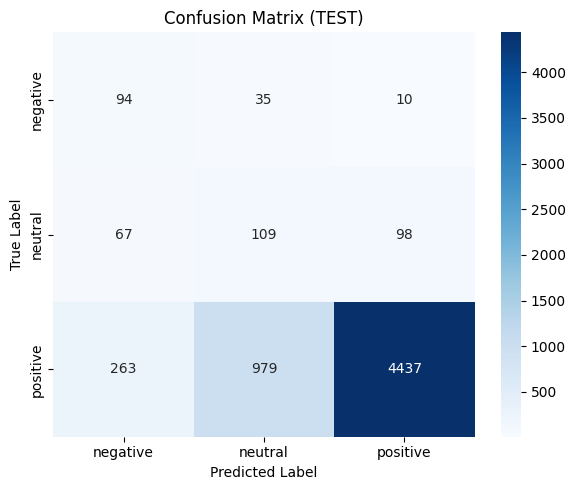

Accuracy (TEST): 0.7616546290216678
Macro F1-score (TEST): 0.4526439406191162
Weighted F1-score (TEST): 0.8237532846282305


In [90]:
# Logistic Regression Model 
clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(emb_train, y_train)

# Validation set
print("=== VALIDATION ===")
pred_val = clf.predict(emb_val)
print(classification_report(y_val, pred_val, digits=3))

# Test Set
print("=== TEST ===")
pred_test = clf.predict(emb_test)

# Classification Report
print(classification_report(y_test, pred_test, digits=3))
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=clf.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()

# Additional Scores
print("Accuracy (TEST):", accuracy_score(y_test, pred_test))
print("Macro F1-score (TEST):", f1_score(y_test, pred_test, average="macro"))
print("Weighted F1-score (TEST):", f1_score(y_test, pred_test, average="weighted"))

- Weighted F1 (overall performance on individual sample) -> stays high (model is great at positive).
- Macro F1 (overal balance) ->  stays low (model is poor on negative/neutral).

**Per-class insights**

* Negative – good recall (0.676) but low precision (0.222): the model finds most negatives but often confuses others as negative.
* Neutral – very low precision (0.097) and moderate recall (0.398): the hardest class for the model to identify.
* Positive – excellent precision (0.976) and solid recall (0.781): reflects the dominance of positive samples in the dataset.


### Downsampling Positives into 3x size of (Negative + Neutral) Combined

In [91]:
# --- Downsample positives in TRAIN only (keep VAL/TEST untouched)
train = X_train.copy()

pos = train[train.label == "positive"]
neu = train[train.label == "neutral"]
neg = train[train.label == "negative"]

# target: make POS about 3x the size of (NEG+NEU) combined
target_pos = int(3 * (len(neu) + len(neg)))

# if we have more positives than target, sample down; else keep all
pos_down = pos.sample(n=min(len(pos), target_pos), random_state=42)

# combine the downsampled positives with all neutrals and negatives, then shuffle and reset the row index
train_balanced = pd.concat([pos_down, neu, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print("TRAIN (original):", X_train.label.value_counts().to_dict())
print("TRAIN (downsampled):", train_balanced.label.value_counts().to_dict())

TRAIN (original): {'positive': 26499, 'neutral': 1277, 'negative': 647}
TRAIN (downsampled): {'positive': 5772, 'neutral': 1277, 'negative': 647}


In [92]:
# Rebuild embeddings using the downsampled TRAIN
emb_train2 = embed(train_balanced["text"].tolist())
y_train2 = train_balanced["label"].tolist()

# (VAL/TEST stay as you already built)
emb_val2   = embed(X_val["text"].tolist())
emb_test2  = embed(X_test["text"].tolist())
y_val   = X_val["label"].tolist()
y_test  = X_test["label"].tolist()

=== VALIDATION (downsampling) ===
              precision    recall  f1-score   support

    negative      0.231     0.727     0.351       139
     neutral      0.089     0.372     0.143       274
    positive      0.979     0.777     0.866      5679

    accuracy                          0.757      6092
   macro avg      0.433     0.625     0.453      6092
weighted avg      0.922     0.757     0.822      6092

=== TEST (downsampling) ===
              precision    recall  f1-score   support

    negative      0.223     0.698     0.338       139
     neutral      0.097     0.398     0.156       274
    positive      0.976     0.779     0.867      5679

    accuracy                          0.760      6092
   macro avg      0.432     0.625     0.454      6092
weighted avg      0.919     0.760     0.823      6092



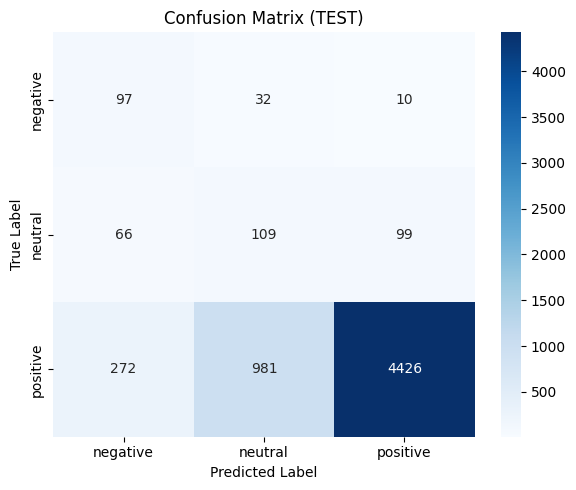

Accuracy (TEST): 0.7603414313854235
Macro F1-score (TEST): 0.4535977217392813
Weighted F1-score (TEST): 0.8226350830844557


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(max_iter=3000, class_weight="balanced")
clf.fit(emb_train2, y_train2)

# Validation set
print("=== VALIDATION (downsampling) ===")
pred_val = clf.predict(emb_val)
print(classification_report(y_val, pred_val, digits=3))

# Test Set
print("=== TEST (downsampling) ===")
pred_test = clf.predict(emb_test)

# Classification Report
print(classification_report(y_test, pred_test, digits=3))
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=clf.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()

# Additional Scores
print("Accuracy (TEST):", accuracy_score(y_test, pred_test))
print("Macro F1-score (TEST):", f1_score(y_test, pred_test, average="macro"))
print("Weighted F1-score (TEST):", f1_score(y_test, pred_test, average="weighted"))


After doing the downsampling, it seems the score is still same as before doing the downsampling 

### LinearSVC

=== VAL (LinearSVC+calibration) ===
              precision    recall  f1-score   support

    negative      0.432     0.482     0.456       139
     neutral      0.248     0.197     0.220       274
    positive      0.961     0.968     0.965      5679

    accuracy                          0.922      6092
   macro avg      0.547     0.549     0.547      6092
weighted avg      0.917     0.922     0.920      6092

=== TEST (LinearSVC+calibration) ===
              precision    recall  f1-score   support

    negative      0.417     0.453     0.434       139
     neutral      0.266     0.197     0.226       274
    positive      0.959     0.969     0.964      5679

    accuracy                          0.923      6092
   macro avg      0.547     0.540     0.542      6092
weighted avg      0.916     0.923     0.919      6092



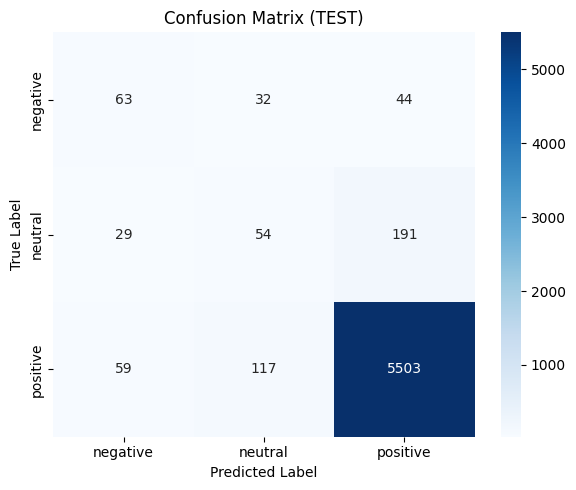

Accuracy (TEST): 0.922521339461589
Macro F1-score (TEST): 0.5416329680081716
Weighted F1-score (TEST): 0.9187447157404693


In [28]:
class_weight = {"negative": 6.0, "neutral": 3.0, "positive": 1.0}

base_svc = LinearSVC(class_weight=class_weight, max_iter=5000)
clf = CalibratedClassifierCV(base_svc, method="sigmoid", cv=3)   # Platt scaling
clf.fit(emb_train2, y_train2)

# Validation set
print("=== VAL (LinearSVC+calibration) ===")
pred_val = clf.predict(emb_val)
print(classification_report(y_val, pred_val, digits=3))

# Test Set
print("=== TEST (LinearSVC+calibration) ===")
pred_test = clf.predict(emb_test)

# Classification Report
print(classification_report(y_test, pred_test, digits=3))
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=clf.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()

# Additional Scores
print("Accuracy (TEST):", accuracy_score(y_test, pred_test))
print("Macro F1-score (TEST):", f1_score(y_test, pred_test, average="macro"))
print("Weighted F1-score (TEST):", f1_score(y_test, pred_test, average="weighted"))


SVC Model significantly improves **Macro F1-Score** and minority-class detecion compared to logistic regression, but additional balanced data or advanced sampling would be needed for strong negative/neutral performance.

### Semantic Search (FAISS)

In [34]:
emb_train.shape

(28423, 384)

In [ ]:
# Get the number of columns (dimension)
dim = emb_train.shape[1]
# cosine via normalized embeddings
faiss_index = faiss.IndexFlatIP(dim)   
faiss_index.add(emb_train)

def topk_similarity(text, k=5):
    vec = embed([text])
    # Search index for k nearest neighbors to vec
    scores, idx = faiss_index.search(vec, k)
    rows = X_train.iloc[idx[0]][["text","label"]].copy()
    rows["score"] = scores[0]
    return rows

# Demo, Picks a random texts from test set 
sample = X_test.sample(1).iloc[0]
print("QUERY:", sample["text"])
# show the 5 most similar training and their similarity
topk_similarity(sample["text"], k=5)

QUERY: Produk baik agak terkendala madalah pengiriman karena eror aplikasi


,text,label,score
13847,"Produk baik, bahan nyaman, agak terkendala kar...",positive,0.815349
7447,"Banyak yang ga lengket...., produk kurang bagus.",negative,0.739876
37553,"Kualitas barang mantap, jasa pengiriman masih ...",positive,0.725452
39537,"kualitas barangnya kurang bagus, tipis, pengir...",neutral,0.722501
18951,"produk cukup baik. packing kurang baik, tidak ...",neutral,0.717981


In [39]:
def predict_with_neighbors(text, k=5):
    vec = embed([text])
    label = clf.predict(vec)[0]
    scores, idx = faiss_index.search(vec, k)
    rows = X_train.iloc[idx[0]][["text","label"]].copy()
    rows["score"] = scores[0]
    return label, rows

lab, rows = predict_with_neighbors("Barang sesuai deskripsi, kualitas bagus dan pengiriman cepat.", 3)
print("Predicted:", lab); display(rows)


Predicted: positive


,text,label,score
22250,Barang bagus berkualitas dan pengiriman cepat,positive,0.945536
39065,Kualitas barang bagus dan pengiriman cepat,positive,0.941386
20771,"Produk bagus sesuai deskripsi, packing baik, p...",positive,0.940268


### Prediction with new Text outside dataset

In [ ]:
# Predict on New text (not in dataset)

def predict_text(text, k=5):
    # Embed new Text
    vec = embed([text])
    
    # Classifier prediction
    pred_label = clf.predict(vec)[0]
    
    # probs
    probs = None
    if hasattr(clf, "predict_proba"):
        # shape (n_classes,)
        prob_score = clf.predict_proba(vec)[0]
        # List Classes into variables
        classes = clf.classes_.tolist()
        # Pair each class with its probability, cast to float
        class_pairs = [(name, float(prob)) for name, prob in zip(classes, prob_score)]
        # Sort by highest prob
        class_pairs = sorted(class_pairs, key=lambda pair: pair[1], reverse=True)
        probs = dict(class_pairs)
    
    # FAISS 
    scores, idx = faiss_index.search(vec,k)
    rows = X_train.iloc[idx[0]][["text","label"]].copy()
    rows["score"] = scores[0]
    
    result = {
        "input_text" : text,
        "prediction" : pred_label,
        "probabilities" : probs,
        "neighbors" : rows
    }
    
    return result

def show_predict(pred):
    print("Text : ", pred["input_text"])
    print("Pred : ", pred["prediction"])
    if pred["probabilities"] is not None:
        print("Probs : ", pred["probabilities"])
    display(pred["neighbors"])

examples = [
    "Barangnya bagus, pengiriman cepat. Recommended!",
    "Sangat mengecewakan, barang cacat dan layanan lambat.",
    "Kualitas oke, tapi packing kurang rapi jadi agak rusak."
]

for review in examples:
    show = predict_text(review, k=3)
    show_predict(show)
    

Text :  Barangnya bagus, pengiriman cepat. Recommended!
Pred :  positive
Probs :  {'positive': 0.9407085472014453, 'neutral': 0.05604480247775654, 'negative': 0.003246650320798151}


,text,label,score
37125,"pengiriman cepat, barangnya bagus. Recommended",positive,0.957810
7609,"Barangnya bagus, pengiriman cepat...",positive,0.956542
39370,"barang bagus, sesuai harga, pengiriman cepat",positive,0.953217


Text :  Sangat mengecewakan, barang cacat dan layanan lambat.
Pred :  negative
Probs :  {'negative': 0.7439041069533275, 'neutral': 0.20636087026234914, 'positive': 0.04973502278432324}


,text,label,score
10863,Pelayanan kurang memuaskan.slow respon sangat,negative,0.733282
5846,Pelayanan sangat lambat,neutral,0.637380
2545,Respon lambat pengiriman lama barang yang di k...,negative,0.614181


Text :  Kualitas oke, tapi packing kurang rapi jadi agak rusak.
Pred :  neutral
Probs :  {'neutral': 0.6011960327320233, 'positive': 0.25581526216264633, 'negative': 0.14298870510533038}


,text,label,score
18951,"produk cukup baik. packing kurang baik, tidak ...",neutral,0.877656
39537,"kualitas barangnya kurang bagus, tipis, pengir...",neutral,0.827538
9218,Produknya oke. Packing nya tidak oke,positive,0.826458


In [72]:
df_sample  = pd.read_csv('data/sample_reviews.csv')
df_sample.head()

,text,label
0,"Barangnya cakep gilaaa, pengiriman sangat cepat",positive
1,"Kualitas nya bagus, tapi kemasan barangnya rusak",neutral
2,"Sangat mengecewakan, respon lama, barang cacat...",negative
3,"Pelayanan top fast respon, produk sesuai deskr...",positive
4,Packing kurang rapi namun barang tetap aman,neutral


In [73]:
for txt in df_sample['text']:
    review = predict_text(txt, k=3)
    show_predict(review)

Text :  Barangnya cakep gilaaa, pengiriman sangat cepat
Pred :  positive
Probs :  {'positive': 0.7152801578588402, 'negative': 0.1588981113178872, 'neutral': 0.12582173082327247}


,text,label,score
1041,Pengiriman barangnya sangat cepat...,positive,0.846877
6114,mantap pengiriman fast top banget deh,positive,0.841028
603,Barang oke pengiriman super cepat,positive,0.839873


Text :  Kualitas nya bagus, tapi kemasan barangnya rusak
Pred :  neutral
Probs :  {'neutral': 0.43681355136014965, 'negative': 0.37178496591702803, 'positive': 0.1914014827228223}


,text,label,score
18951,"produk cukup baik. packing kurang baik, tidak ...",neutral,0.813778
15030,boxnya sedikit rusak tapi overall bagus barangnya,positive,0.789170
39510,"Produknya bagus sih, sayangnya kekecilan pas d...",positive,0.788341


Text :  Sangat mengecewakan, respon lama, barang cacat dan pengiriman pun juga lama 
Pred :  negative
Probs :  {'negative': 0.6844187278234689, 'neutral': 0.27412839127374394, 'positive': 0.04145288090278721}


,text,label,score
16688,Sangat mengecewakan. Sudah retur untuk perbaik...,negative,0.738833
2545,Respon lambat pengiriman lama barang yang di k...,negative,0.682938
9446,barang tidak sesuai dengan pesanan... pengirim...,neutral,0.670425


Text :  Pelayanan top fast respon, produk sesuai deskripsi
Pred :  positive
Probs :  {'positive': 0.9333242588867793, 'neutral': 0.060012029590683656, 'negative': 0.006663711522537093}


,text,label,score
27794,"fast response, barang sesuai dengan deskripsi ...",positive,0.865373
32299,fast response pelayanan ramah barang yang dite...,positive,0.861991
30046,"Pelayanan mantabs, fast respon. Untuk barang o...",positive,0.853921


Text :  Packing kurang rapi namun barang tetap aman
Pred :  positive
Probs :  {'positive': 0.6718763657562011, 'neutral': 0.2681648710777837, 'negative': 0.05995876316601503}


,text,label,score
23829,Packing kurang aman tp untung barang aman...,positive,0.907316
24024,"Packing baik, barang aman",positive,0.875025
27117,"Packing aman, agak lama nyampenya",positive,0.874778


### Save model

In [77]:
MODEL_PATH = "model"
os.makedirs(MODEL_PATH, exist_ok=True)

In [78]:
joblib.dump(clf, os.path.join(MODEL_PATH, "lr_sentiment.pkl"))
faiss.write_index(faiss_index, os.path.join(MODEL_PATH, "faiss.index"))